In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

## Stochastic Setup

Let us specify the transition rates:
$$\begin{aligned}
\mathbb{P}(S \rightarrow E) &= \beta SI/N\\
\mathbb{P}(E \rightarrow I) &= \gamma E\\
\mathbb{P}(I \rightarrow R) &= \alpha I\\
\end{aligned}$$

These transition rates are then used in the CTMC forumlation.

In [2]:
def det_model(state, p):
    b, g, a = p
    s, e, i, r = state
    n = sum(state)
    return [
        -b*s*i/n,
        b*s*i/n - g*e,
        g*e - a*i,
        a*i
    ]

def transition(state, p):
    b, g, a = p
    s, e, i, r = state
    n = sum(state)
    update = copy.copy(state)
    # time to next event
    bins = np.array([b*s*i/n, g*e, a*i])
    sbins = np.linalg.norm(bins, ord=1)
    dt = np.random.exponential(1/sbins)
    # draw type of event and propagate
    bins /= sbins
    seed = np.random.uniform()
    x = np.digitize(seed, np.cumsum(bins))
    x = max(min(x, 2), 0)
    update[x] -= 1
    update[x+1] += 1
    return dt, update

In [3]:
y0 = [100, 0, 1, 0]
p0 = [5, 0.1, 0.1]
    
def realise(y0, p):
    history = {'t': [], 'y':[]}
    t = 0
    y = y0

    T = 10000
    while t < T:
        history['t'].append(t)
        history['y'].append(y)
        if sum(y[1:-1]) == 0:
            break
        dt, y = transition(y, p0)
        t += dt
        
    return history

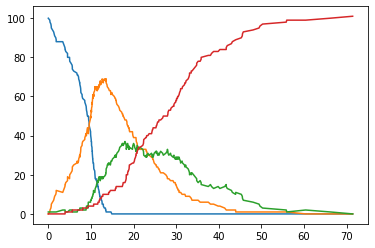

In [4]:
stoch = realise(y0, p0)
plt.plot(stoch['t'], stoch['y'])

In [5]:
realisations = [realise(y0, p0) for _ in range(100)]

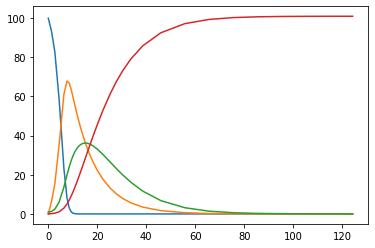

In [6]:
from scipy.integrate import solve_ivp

sol = solve_ivp(lambda t, y: det_model(y, p0), [0, max(r['t'][-1] for r in realisations)], y0, dense_output=True)
plt.plot(sol.t, sol.y.T)

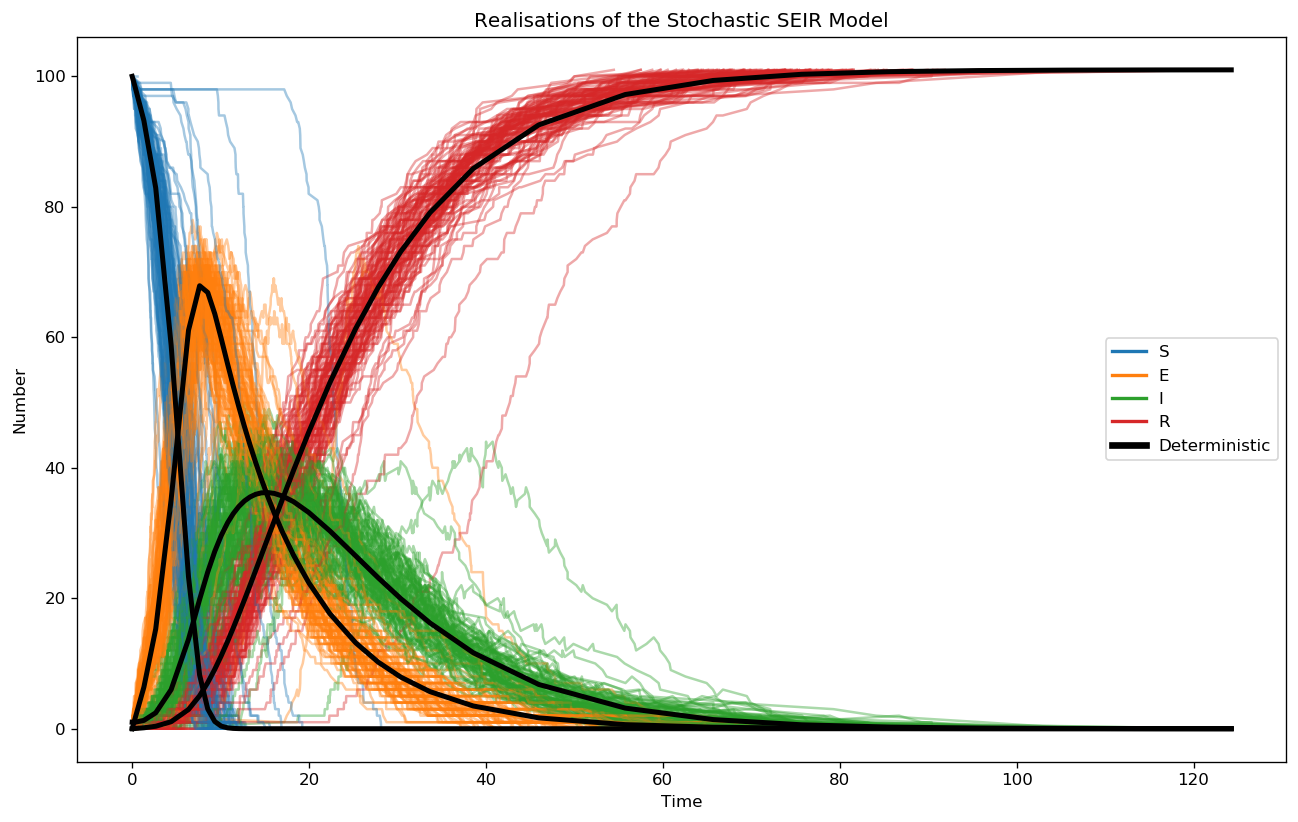

In [7]:
plt.figure(figsize=[13, 8], dpi=120)
dColours = plt.rcParams['axes.prop_cycle'].by_key()['color']
for realisation in realisations:
    plt.plot(realisation['t'], [k[0] for k in realisation['y']], dColours[0], alpha=0.4, label='S')
    plt.plot(realisation['t'], [k[1] for k in realisation['y']], dColours[1], alpha=0.4, label='E')
    plt.plot(realisation['t'], [k[2] for k in realisation['y']], dColours[2], alpha=0.4, label='I')
    plt.plot(realisation['t'], [k[3] for k in realisation['y']], dColours[3], alpha=0.4, label='R')
plt.plot(sol.t, sol.y.T, 'k', linewidth=3);

plt.title('Realisations of the Stochastic SEIR Model')
plt.xlabel('Time')
plt.ylabel('Number')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=dColours[0], lw=2),
                Line2D([0], [0], color=dColours[1], lw=2),
                Line2D([0], [0], color=dColours[2], lw=2),
                Line2D([0], [0], color=dColours[3], lw=2),
                Line2D([0], [0], color='k', lw=4)]
plt.legend(custom_lines, ['S', 'E', 'I', 'R', 'Deterministic'])

In [8]:
dydt = np.abs(np.array([det_model(state, p0) for state in sol.y.T]))

In [9]:
discr = []
for t in np.linspace(0, 100, 101):
    expect = sol.sol(t)[-1]
    tscore = []
    for realisation in realisations:
        tscore.append(np.interp(t, realisation['t'], [r[-1] for r in realisation['y']]))
    discr.append(np.mean(np.abs(np.array(tscore)-expect)))

Text(0, 0.5, '$\\mu_{|R_{stoch}-R_{determ}|}$')

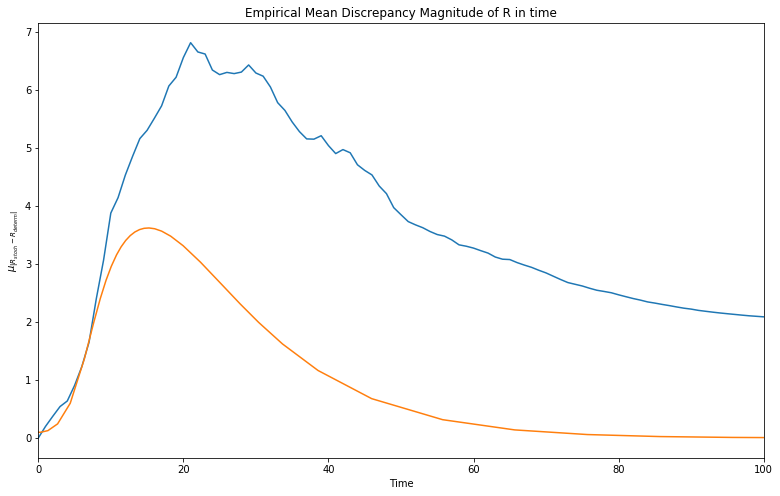

In [10]:
plt.figure(figsize=[13,8])
plt.plot(discr)
plt.plot(sol.t, dydt[:,-1])
plt.xlim([0,100])
plt.title('Empirical Mean Discrepancy Magnitude of R in time')
plt.xlabel('Time')
plt.ylabel(r'$\mu_{|R_{stoch}-R_{determ}|}$')

In [11]:
idiscr = []
for t in np.linspace(0, 100, 101):
    expect = sol.sol(t)[2]
    tscore = []
    for realisation in realisations:
        tscore.append(np.interp(t, realisation['t'], [r[2] for r in realisation['y']]))
    idiscr.append(np.mean(np.abs(np.array(tscore)-expect)))

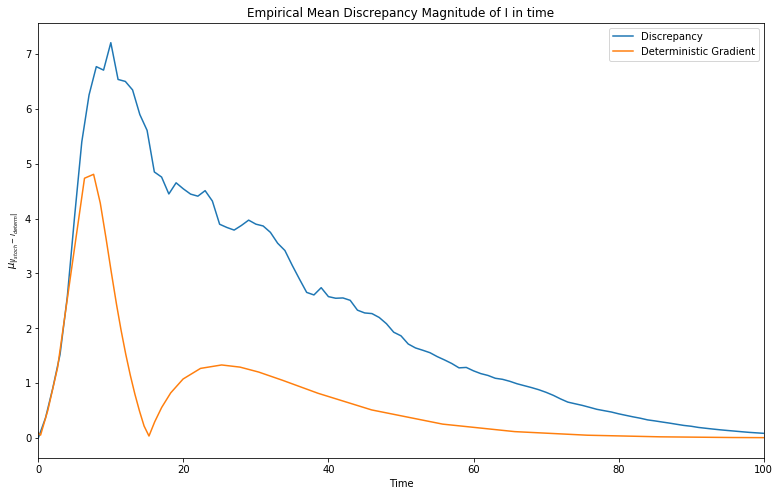

In [12]:
plt.figure(figsize=[13,8])
plt.plot(idiscr)
plt.plot(sol.t, dydt[:,2])
plt.xlim([0,100])
plt.title('Empirical Mean Discrepancy Magnitude of I in time')
plt.xlabel('Time')
plt.ylabel(r'$\mu_{|I_{stoch}-I_{determ}|}$')
plt.legend(['Discrepancy', 'Deterministic Gradient'])

In [13]:
ediscr = []
for t in np.linspace(0, 100, 101):
    expect = sol.sol(t)[1]
    tscore = []
    for realisation in realisations:
        tscore.append(np.interp(t, realisation['t'], [r[1] for r in realisation['y']]))
    ediscr.append(np.mean(np.abs(np.array(tscore)-expect)))

Text(0, 0.5, '$\\mu_{|E_{stoch}-E_{determ}|}$')

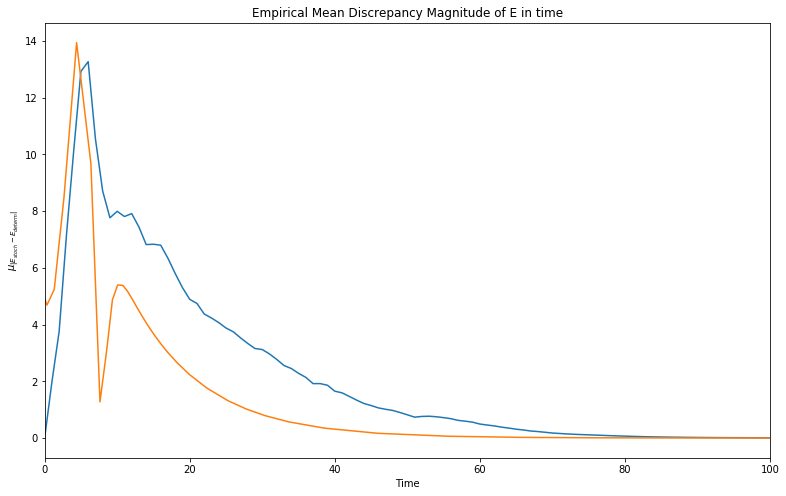

In [14]:
plt.figure(figsize=[13,8])
plt.plot(ediscr)
plt.plot(sol.t, dydt[:,1])
plt.xlim([0,100])
plt.title('Empirical Mean Discrepancy Magnitude of E in time')
plt.xlabel('Time')
plt.ylabel(r'$\mu_{|E_{stoch}-E_{determ}|}$')

In [15]:
sdiscr = []
for t in np.linspace(0, 100, 101):
    expect = sol.sol(t)[0]
    tscore = []
    for realisation in realisations:
        tscore.append(np.interp(t, realisation['t'], [r[0] for r in realisation['y']]))
    sdiscr.append(np.mean(np.abs(np.array(tscore)-expect)))

Text(0, 0.5, '$\\mu_{|S_{stoch}-S_{determ}|}$')

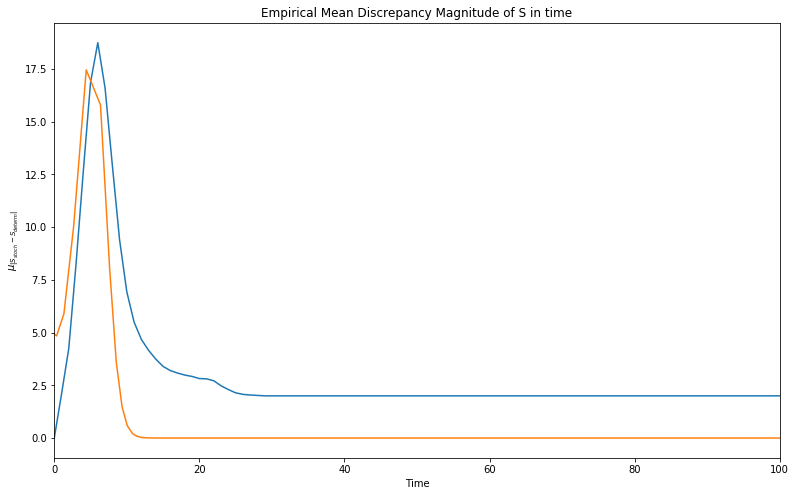

In [16]:
plt.figure(figsize=[13,8])
plt.plot(sdiscr)
plt.plot(sol.t, dydt[:,0])
plt.xlim([0,100])
plt.title('Empirical Mean Discrepancy Magnitude of S in time')
plt.xlabel('Time')
plt.ylabel(r'$\mu_{|S_{stoch}-S_{determ}|}$')

In [17]:
import fitter, modeller
import casadi as ca


In [18]:
def mod_model(t, state, p):
    b, g, a = p
    s, e, i, r, c = state
    n = s+e+i+r
    return [
        -b*s*i/n,
        b*s*i/n - g*e,
        g*e - a*i,
        a*i,
        g*e
    ]

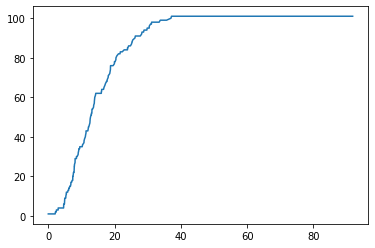

In [19]:
# choose realisation
data = np.random.choice(realisations)
data_y = np.array(data['y'])
# compute cumulative entries into I
I = data_y[:,2]
eI = [1 if I[i]-I[i-1] > 0 else 0 for i in range(1,len(I))]
eI.insert(0, I[0])
cI = np.cumsum(eI)
plt.plot(data['t'], cI)

In [20]:
data_pd = np.array([[i] for i in cI])
data_time = np.array(data['t'])

In [21]:
model_form= {
        "state": 5,
        "parameters": 3
    }
p0guess = [1.5, 1e-6, 1e-6]
config = {
    "grid_size": 200,
    "basis_number": 40,
    "model_form": model_form,
    "time_span": [data_time[0], data_time[-1]*1.25],
    "knot_function": None,
    "model": mod_model,
    "dataset": {"y": data_pd, "t": data_time},
    "observation_vector": [-1],
    "weightings":[
        [1]*model_form['state'],
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy.copy(p0guess),
}

In [22]:
model = modeller.Model(config)
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 50,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [23]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [24]:
c0 = [100*np.ones(config['basis_number']) for _ in range(model_form['state'])]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*model_form['state']) + [0]*len(config['regularisation_value'])
alpha = 1e2

In [25]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3790
Number of nonzeros in Lagrangian Hessian.............:     3131

Total number of variables............................:      203
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

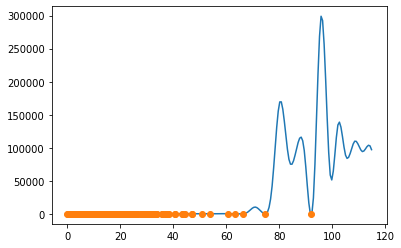

In [26]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(data_time, cI, 'o')

In [27]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3790
Number of nonzeros in Lagrangian Hessian.............:     3131

Total number of variables............................:      203
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

  50 1.2721744e+000 0.00e+000 6.97e-001  -5.7 5.22e+003    -  1.00e+000 5.00e-001h  2
 100 1.2721114e+000 0.00e+000 4.35e-003  -8.6 1.45e+004    -  1.00e+000 3.12e-002h  6
 150 1.2721114e+000 0.00e+000 4.47e-004  -8.6 2.03e+002 -15.8 1.00e+000 1.00e+000h  1
 200 1.2721114e+000 0.00e+000 6.75e-005  -8.6 1.24e+003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 248

                                   (scaled)                 (unscaled)
Objective...............:  1.2721113802659192e+000   1.2721113802659192e+000
Dual infeasibility......:  2.7635789116116014e-009   2.7635789116116014e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059037384717362e-009   2.5059037384717362e-009
Overall NLP error.......:  2.7635789116116014e-009   2.7635789116116014e-009


Number of objective function evaluations             = 666
Number of objective gradient evaluations             = 249
Number of equality constraint evaluations       

 200 1.2721195e+000 0.00e+000 1.39e-003  -8.6 8.38e+001 -15.9 1.00e+000 1.00e+000h  1
 250 1.2721195e+000 0.00e+000 3.93e-004  -8.6 7.86e+002    -  1.00e+000 6.25e-002h  5
 300 1.2721192e+000 0.00e+000 9.16e-004  -9.0 2.07e+002    -  1.00e+000 5.00e-001h  2

Number of Iterations....: 309

                                   (scaled)                 (unscaled)
Objective...............:  1.2721191824325091e+000   1.2721191824325091e+000
Dual infeasibility......:  2.7281330067740160e-012   2.7281330067740160e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.0909090909090931e-010   9.0909090909090931e-010
Overall NLP error.......:  9.0909090909090931e-010   9.0909090909090931e-010


Number of objective function evaluations             = 591
Number of objective gradient evaluations             = 310
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 591
Number of equality

  50 1.2721584e+000 0.00e+000 2.01e-001  -5.7 2.19e+003    -  1.00e+000 2.50e-001h  3
 100 1.2721433e+000 0.00e+000 4.91e-003  -8.6 4.47e+002 -14.3 1.00e+000 1.00e+000h  1
 150 1.2721404e+000 0.00e+000 2.34e-003  -8.6 8.32e+001 -13.8 1.00e+000 1.00e+000h  1
 200 1.2721380e+000 0.00e+000 3.99e-004  -8.6 7.99e+002 -15.7 1.00e+000 6.25e-002h  5
 250 1.2721381e+000 0.00e+000 3.69e-004  -8.6 4.66e+001 -17.6 1.00e+000 5.00e-001h  2

Number of Iterations....: 268

                                   (scaled)                 (unscaled)
Objective...............:  1.2721377640619427e+000   1.2721377640619427e+000
Dual infeasibility......:  2.5682930647648317e-009   2.5682930647648317e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.0909764791768476e-010   9.0909764791768476e-010
Overall NLP error.......:  2.5682930647648317e-009   2.5682930647648317e-009


Number of objective function evaluations             = 513
Number of objective g

  50 1.2721996e+000 0.00e+000 9.59e-005  -8.6 3.85e+001 -12.8 1.00e+000 1.00e+000h  1
 100 1.2721924e+000 0.00e+000 1.44e-003  -8.6 5.05e+002 -14.1 1.00e+000 1.00e+000h  1
 150 1.2721858e+000 0.00e+000 4.27e-002  -8.6 4.17e+002 -13.5 1.00e+000 1.00e+000h  1
 200 1.2721813e+000 0.00e+000 7.04e-002  -8.6 7.16e+002 -15.2 1.00e+000 5.00e-001h  2
 250 1.2721810e+000 0.00e+000 4.64e-008  -8.6 5.83e-001 -14.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 254

                                   (scaled)                 (unscaled)
Objective...............:  1.2721809748813533e+000   1.2721809748813533e+000
Dual infeasibility......:  7.5608981423870569e-012   7.5608981423870569e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596800564e-009   2.5059035596800564e-009
Overall NLP error.......:  2.5059035596800564e-009   2.5059035596800564e-009


Number of objective function evaluations             = 412
Number of objective g

  50 1.2723222e+000 0.00e+000 3.29e-002  -8.6 1.98e+003 -13.7 1.00e+000 5.68e-001h  1
 100 1.2722977e+000 0.00e+000 4.33e-002  -8.6 7.16e+002 -13.2 1.00e+000 6.89e-001h  1
 150 1.2722832e+000 0.00e+000 1.06e-002  -8.6 2.15e+002 -13.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 195

                                   (scaled)                 (unscaled)
Objective...............:  1.2722801283420966e+000   1.2722801283420966e+000
Dual infeasibility......:  4.6646618953008652e-009   4.6646618953008652e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035685771126e-009   2.5059035685771126e-009
Overall NLP error.......:  4.6646618953008652e-009   4.6646618953008652e-009


Number of objective function evaluations             = 509
Number of objective gradient evaluations             = 196
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 509
Number of equality

  50 1.2726105e+000 0.00e+000 7.74e-005  -5.7 3.81e+000 -12.3 1.00e+000 1.00e+000h  1
 100 1.2725600e+000 0.00e+000 5.87e-002  -8.6 4.84e+002 -13.4 1.00e+000 1.00e+000h  1
 150 1.2725286e+000 0.00e+000 2.00e-001  -8.6 3.26e+002 -13.8 1.00e+000 1.00e+000h  1
 200 1.2725098e+000 0.00e+000 3.91e-002  -8.6 3.04e+003 -15.0 1.00e+000 2.72e-002h  2
 250 1.2725088e+000 0.00e+000 1.42e-009  -9.0 2.44e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 250

                                   (scaled)                 (unscaled)
Objective...............:  1.2725087645809667e+000   1.2725087645809667e+000
Dual infeasibility......:  1.4192241863734663e-009   1.4192241863734663e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.0909090909090931e-010   9.0909090909090931e-010
Overall NLP error.......:  1.4192241863734663e-009   1.4192241863734663e-009


Number of objective function evaluations             = 409
Number of objective g

  50 1.2748298e+000 0.00e+000 4.47e-004  -3.8 5.39e+000    -  1.00e+000 1.00e+000h  1
 100 1.2731267e+000 0.00e+000 5.03e-002  -8.6 4.91e+002 -13.0 1.00e+000 1.00e+000h  1
 150 1.2730609e+000 0.00e+000 1.30e-002  -8.6 1.14e+002 -12.4 1.00e+000 1.00e+000h  1
 200 1.2730383e+000 0.00e+000 8.27e-002  -8.6 6.39e+001 -13.7 7.52e-001 1.00e+000h  1
 250 1.2730376e+000 0.00e+000 1.76e-004  -8.6 6.91e-001 -12.4 1.00e+000 1.00e+000h  1
 300 1.2730376e+000 0.00e+000 1.50e-002  -8.6 1.49e+001 -14.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 314

                                   (scaled)                 (unscaled)
Objective...............:  1.2730376233795464e+000   1.2730376233795464e+000
Dual infeasibility......:  5.7723972357679593e-012   5.7723972357679593e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596800564e-009   2.5059035596800564e-009
Overall NLP error.......:  2.5059035596800564e-009   2.5059035596800564e-

  50 1.2758055e+000 0.00e+000 1.89e+000  -3.8 1.67e+002 -10.8 1.00e+000 1.00e+000f  1
 100 1.2747661e+000 0.00e+000 3.02e-001  -5.7 3.42e+002 -12.4 1.00e+000 1.00e+000h  1
 150 1.2745416e+000 0.00e+000 5.71e-001  -5.7 3.28e+003    -  1.00e+000 6.25e-002h  5
 200 1.2744411e+000 0.00e+000 7.98e-001  -8.6 8.78e+002 -12.9 1.00e+000 5.00e-001h  2
 250 1.2742984e+000 0.00e+000 5.42e-002  -8.6 2.25e+002 -12.4 1.00e+000 1.00e+000h  1
 300 1.2742588e+000 0.00e+000 2.68e-001  -8.6 2.45e+001 -13.7 2.96e-001 5.00e-001h  2
 350 1.2742565e+000 0.00e+000 5.01e-003  -8.6 2.17e+001 -14.8 1.00e+000 1.00e+000h  1
 400 1.2742557e+000 0.00e+000 3.77e-006  -8.6 1.13e-001 -12.0 1.00e+000 1.00e+000h  1
 450 1.2742548e+000 0.00e+000 1.66e-002  -8.6 1.48e+002 -14.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.2743065e+000 0.00e+000 4.02e+000  -8.6 2.22e+003 -11.7 4.61e-007 1.94e-005f  9

Number of Iterations....: 513

                           

 200 1.2771608e+000 0.00e+000 2.96e-001  -8.6 3.18e+001  -9.9 1.00e+000 1.00e+000f  1
 250 1.2770732e+000 0.00e+000 5.65e-003  -8.6 1.99e+002 -13.9 1.00e+000 1.00e+000h  1
 300 1.2771596e+000 0.00e+000 1.78e+001  -8.6 8.50e+004 -11.0 2.69e-010 1.44e-015h 36
 350 1.2770640e+000 0.00e+000 1.53e-002  -8.6 2.89e+001 -14.1 1.00e+000 1.00e+000h  1
 400 1.2770626e+000 0.00e+000 8.85e-002  -8.6 3.46e+001 -13.1 1.00e+000 5.00e-001h  2
 450 1.2770602e+000 0.00e+000 3.86e-001  -8.6 7.75e+002 -14.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.2770566e+000 0.00e+000 8.33e-005  -8.6 9.16e+000 -12.4 1.00e+000 1.00e+000h  1
 550 1.2770394e+000 0.00e+000 7.35e-004  -8.6 1.50e+001 -11.9 9.55e-001 1.00e+000h  1

Number of Iterations....: 565

                                   (scaled)                 (unscaled)
Objective...............:  1.2770328596455762e+000   1.2770328596455762e+000
Dual infeasibility......:  8.7649502330805343e-010 

  50 1.2864353e+000 0.00e+000 8.60e-001  -5.7 4.78e+002 -11.8 1.00e+000 1.00e+000h  1
 100 1.2853864e+000 0.00e+000 2.21e+000  -5.7 9.79e+002 -12.2 1.00e+000 5.00e-001h  2
 150 1.2844231e+000 0.00e+000 5.05e+000  -5.7 9.78e+002 -12.5 1.00e+000 5.00e-001h  2
 200 1.2837934e+000 0.00e+000 8.16e-003  -8.6 1.23e+001 -10.3 1.00e+000 1.00e+000f  1
 250 1.2835281e+000 0.00e+000 8.97e-001  -8.6 9.07e+001 -13.4 1.00e+000 3.68e-002h  1
 300 1.2835117e+000 0.00e+000 3.55e-003  -8.6 6.21e+001 -13.7 1.00e+000 1.00e+000h  1
 350 1.2835082e+000 0.00e+000 9.98e-002  -8.6 2.82e+002 -14.1 1.00e+000 1.00e+000h  1
 400 1.2835015e+000 0.00e+000 2.26e-004  -8.6 3.10e+000 -11.8 1.00e+000 1.00e+000h  1
 450 1.2834819e+000 0.00e+000 2.21e-001  -8.6 2.40e+002 -13.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.2833298e+000 0.00e+000 8.09e-002  -8.6 3.24e+002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 504

                           

 400 1.2921944e+000 0.00e+000 4.06e-001  -8.6 3.48e+001 -10.5 1.00e+000 1.00e+000f  1
 450 1.2919648e+000 0.00e+000 7.65e-001  -8.6 3.00e+002 -13.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.2919632e+000 0.00e+000 9.85e-002  -8.6 4.74e+001 -14.0 1.00e+000 1.00e+000h  1
 550 1.2919615e+000 0.00e+000 2.53e-004  -8.6 2.01e+001 -13.4 1.00e+000 1.00e+000h  1
 600 1.2919595e+000 0.00e+000 5.65e-003  -8.6 7.00e+001 -13.8 1.00e+000 1.00e+000h  1
 650 1.2919561e+000 0.00e+000 1.12e-001  -8.6 2.77e+002 -14.2 1.00e+000 1.00e+000h  1
 700 1.2919514e+000 0.00e+000 8.81e-002  -8.6 8.62e+000 -11.9 1.00e+000 1.00e+000h  1
 750 1.2919430e+000 0.00e+000 2.14e-002  -8.6 8.77e+001 -13.1 1.00e+000 1.00e+000h  1
 800 1.2919186e+000 0.00e+000 4.37e-002  -8.6 9.15e+001 -12.6 1.00e+000 1.00e+000h  1
 850 1.2917136e+000 0.00e+000 9.45e-001  -8.6 3.17e+002 -12.1 8.59e-001 4.24e-001h  1
 900 1.2913532e+000 0.00e+000 1.12e-004  -8.6 3.16e+000 -14

 350 1.3073443e+000 0.00e+000 1.92e+000  -5.7 1.39e+002 -11.2 1.00e+000 1.00e+000h  1
 400 1.3068325e+000 0.00e+000 2.13e+001  -8.6 3.57e+001 -10.4 1.00e+000 8.34e-001f  1
 450 1.3066258e+000 0.00e+000 6.58e-003  -8.6 1.98e+001 -13.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.3066232e+000 0.00e+000 1.06e-003  -8.6 8.30e+000 -12.9 1.00e+000 1.00e+000h  1
 550 1.3066202e+000 0.00e+000 7.86e-004  -8.6 1.04e+000 -11.5 1.00e+000 1.00e+000h  1
 600 1.3066160e+000 0.00e+000 3.44e-004  -8.6 1.27e+001 -12.8 1.00e+000 1.00e+000h  1
 650 1.3066091e+000 0.00e+000 2.00e-004  -8.6 6.59e+000 -12.2 1.00e+000 1.00e+000h  1
 700 1.3065944e+000 0.00e+000 1.15e-001  -8.6 9.57e+001 -13.0 1.00e+000 1.00e+000h  1
 750 1.3065560e+000 0.00e+000 5.06e-002  -8.6 7.99e+001 -12.4 1.00e+000 1.00e+000h  1
 800 1.3062557e+000 0.00e+000 1.64e-001  -8.6 6.45e+001 -11.0 1.00e+000 1.00e+000h  1
 850 1.3046017e+000 0.00e+000 2.02e-004  -8.6 3.03e+000 -13

 150 1.2302648e+001 0.00e+000 3.68e+003  -1.7 1.19e+003  -9.2 1.00e+000 6.13e-001f  1
 200 1.7636265e+000 0.00e+000 3.72e+002  -1.7 8.47e+002    -  1.00e+000 1.00e+000f  1
 250 1.3450009e+000 0.00e+000 4.25e+001  -3.8 3.71e+002    -  1.00e+000 5.00e-001h  2
 300 1.3411453e+000 0.00e+000 6.12e-001  -5.7 7.60e+002 -11.2 1.00e+000 4.84e-001f  2
 350 1.3364041e+000 0.00e+000 1.33e+001  -5.7 6.79e+002 -11.6 1.00e+000 5.00e-001f  2
 400 1.3325291e+000 0.00e+000 1.74e+000  -5.7 2.63e+003 -12.0 1.00e+000 8.69e-002h  4
 450 1.3324063e+000 0.00e+000 1.63e+000  -5.7 3.18e+002    -  1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.3320908e+000 0.00e+000 5.26e+000  -8.6 5.95e+002 -13.2 1.00e+000 1.00e+000h  1
 550 1.3320691e+000 0.00e+000 4.88e-005  -8.6 6.88e+000 -12.7 1.00e+000 1.00e+000h  1
 600 1.3320649e+000 0.00e+000 4.46e-004  -8.6 2.82e+000 -12.2 1.00e+000 1.00e+000h  1
 650 1.3320592e+000 0.00e+000 1.96e-002  -8.6 7.78e+001 -13

  50 3.6844551e+001 0.00e+000 1.87e+002  -1.0 6.09e+002  -8.3 1.00e+000 1.00e+000f  1
 100 3.4659310e+001 0.00e+000 8.35e+002  -2.5 2.74e+003  -9.6 6.45e-001 1.00e+000f  1
 150 2.6547474e+001 0.00e+000 2.17e+003  -2.5 6.67e+002  -9.4 1.00e+000 1.00e+000f  1
 200 4.5410664e+000 0.00e+000 2.27e+003  -2.5 4.89e+003    -  6.69e-001 1.25e-001f  4
 250 1.4271567e+000 0.00e+000 4.16e+002  -2.5 5.27e+002  -8.5 1.00e+000 2.50e-001f  3
 300 1.4221808e+000 0.00e+000 2.99e+002  -2.5 2.10e+004    -  1.00e+000 1.04e-001f  3
 350 1.4177053e+000 0.00e+000 3.28e+002  -2.5 5.16e+003 -11.7 1.00e+000 1.29e-001f  3
 400 1.3984378e+000 0.00e+000 7.54e+000  -3.8 1.85e+002 -10.8 1.00e+000 1.00e+000h  1
 450 1.3936500e+000 0.00e+000 1.21e-003  -3.8 8.76e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.3851763e+000 0.00e+000 6.29e+001  -5.7 8.92e+002 -11.7 4.05e-001 5.00e-001f  2
 550 1.3787863e+000 0.00e+000 1.34e+002  -5.7 4.51e+002 -11

  50 3.8216463e+001 0.00e+000 3.81e+003  -1.0 3.23e+003    -  1.00e+000 5.00e-001f  2
 100 3.4104200e+001 0.00e+000 4.94e+003  -2.5 1.88e+003  -9.7 6.12e-001 2.00e-001f  1
 150 2.6983212e+001 0.00e+000 9.47e+003  -2.5 1.37e+003  -9.6 1.00e+000 8.29e-001f  1
 200 8.8724085e+000 0.00e+000 2.28e+003  -2.5 5.25e+002  -8.6 1.00e+000 1.00e+000f  1
 250 1.5238428e+000 0.00e+000 7.42e+002  -2.5 1.89e+004    -  1.00e+000 3.12e-002f  6
 300 1.5050284e+000 0.00e+000 1.05e+003  -2.5 4.47e+002  -9.5 1.00e+000 1.00e+000f  1
 350 1.5132356e+000 0.00e+000 9.46e+002  -2.5 4.52e+003    -  1.00e+000 5.00e-001f  2
 400 1.4993403e+000 0.00e+000 7.37e+001  -3.8 4.57e+004    -  3.34e-001 1.56e-002f  7
 450 1.4844782e+000 0.00e+000 4.01e-001  -3.8 1.11e+002  -9.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.4742007e+000 0.00e+000 4.86e-002  -3.8 3.44e+001 -11.7 1.00e+000 1.00e+000h  1
 550 1.4636484e+000 0.00e+000 6.02e+001  -5.7 1.31e+002 -10

 100 3.5636903e+001 0.00e+000 1.88e+003  -2.5 2.70e+003 -10.1 1.00e+000 1.00e+000f  1
 150 3.1567067e+001 0.00e+000 4.92e+003  -2.5 1.19e+003  -9.9 1.00e+000 5.34e-001f  1
 200 2.1313993e+001 0.00e+000 1.07e+003  -2.5 3.24e+002  -9.3 1.00e+000 1.00e+000f  1
 250 5.0534823e+000 0.00e+000 5.03e+003  -2.5 6.70e+002  -9.0 1.00e+000 1.00e+000f  1
 300 1.6924305e+000 0.00e+000 9.88e+001  -2.5 4.81e+002  -8.7 1.00e+000 1.00e+000f  1
 350 1.6612706e+000 0.00e+000 4.48e+002  -2.5 5.61e+001  -8.0 1.00e+000 1.00e+000f  1
 400 1.6652777e+000 0.00e+000 4.00e+001  -2.5 2.74e+001  -8.6 1.00e+000 1.00e+000f  1
 450 1.6775306e+000 0.00e+000 4.57e+002  -2.5 1.50e+003    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.6660109e+000 0.00e+000 2.60e+000  -3.8 3.59e+000  -8.1 1.00e+000 1.00e+000h  1
 550 1.6437688e+000 0.00e+000 2.81e+001  -3.8 2.83e+002 -10.2 1.00e+000 1.00e+000f  1
 600 1.6173770e+000 0.00e+000 2.60e-001  -3.8 5.42e+001  -9

  50 3.8022755e+001 0.00e+000 1.90e+002  -1.0 2.23e+002  -7.5 1.00e+000 1.00e+000f  1
 100 3.6412915e+001 0.00e+000 2.04e+003  -2.5 2.45e+003 -10.3 1.00e+000 3.33e-001f  1
 150 3.3739988e+001 0.00e+000 9.14e+003  -2.5 1.02e+003 -10.1 1.00e+000 1.00e+000f  1
 200 2.8934635e+001 0.00e+000 1.32e+004  -2.5 6.29e+002 -10.0 1.00e+000 1.00e+000f  1
 250 1.7851041e+001 0.00e+000 1.81e+004  -2.5 7.69e+002  -9.0 1.00e+000 1.00e+000f  1
 300 4.1646797e+000 0.00e+000 3.26e+003  -2.5 7.83e+002  -8.4 1.00e+000 2.50e-001f  3
 350 1.9904455e+000 0.00e+000 2.22e+001  -2.5 7.53e+001  -7.8 1.00e+000 1.00e+000f  1
 400 1.9464332e+000 0.00e+000 1.83e+002  -2.5 5.35e+002  -8.9 1.00e+000 1.00e+000f  1
 450 1.9506227e+000 0.00e+000 2.55e+003  -2.5 1.65e+004    -  1.00e+000 3.63e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.9594355e+000 0.00e+000 1.61e+003  -2.5 1.68e+004    -  1.00e+000 1.25e-001f  4
 550 1.9642686e+000 0.00e+000 4.39e+002  -2.5 8.21e+002    

1400 1.5774794e+000 0.00e+000 1.42e+002  -8.6 1.33e+002 -10.1 1.00e+000 1.00e+000f  1
1450 1.5737716e+000 0.00e+000 2.36e+001  -8.6 1.97e+002 -11.4 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 1.5729932e+000 0.00e+000 3.02e-004  -8.6 4.89e+001 -11.8 1.00e+000 1.00e+000f  1
1550 1.5687543e+000 0.00e+000 6.35e-003  -8.6 2.68e+000  -7.6 1.00e+000 1.00e+000f  1

Number of Iterations....: 1577

                                   (scaled)                 (unscaled)
Objective...............:  1.5655264324880522e+000   1.5655264324880522e+000
Dual infeasibility......:  1.1488925297231667e-009   1.1488925297231667e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5151962307195649e-009   2.5151962307195649e-009
Overall NLP error.......:  2.5151962307195649e-009   2.5151962307195649e-009


Number of objective function evaluations             = 2535
Number of objective grad

  50 3.8439423e+001 0.00e+000 6.11e+002  -1.0 2.96e+002  -8.0 1.00e+000 1.00e+000f  1
 100 3.7266531e+001 0.00e+000 2.23e+003  -2.5 1.01e+003  -9.8 1.00e+000 7.22e-001f  1
 150 3.5275242e+001 0.00e+000 1.14e+004  -2.5 5.44e+002  -9.3 1.00e+000 1.00e+000f  1
 200 3.2238308e+001 0.00e+000 6.25e+003  -2.5 3.07e+002  -8.8 1.00e+000 1.00e+000f  1
 250 2.6628476e+001 0.00e+000 4.60e+003  -2.5 3.38e+002  -9.1 1.00e+000 1.00e+000f  1
 300 1.7518132e+001 0.00e+000 3.36e+004  -2.5 1.13e+003  -9.4 1.00e+000 1.00e+000f  1
 350 6.2020720e+000 0.00e+000 4.06e+003  -2.5 2.27e+002  -8.4 1.00e+000 1.00e+000f  1
 400 2.8422129e+000 0.00e+000 5.68e+002  -2.5 1.70e+002  -8.3 1.00e+000 1.00e+000f  1
 450 2.7784494e+000 0.00e+000 2.12e+002  -2.5 1.21e+002  -8.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 2.7697871e+000 0.00e+000 3.26e+001  -2.5 2.90e+001  -8.1 1.00e+000 1.00e+000f  1
 550 2.7679830e+000 0.00e+000 1.54e+003  -2.5 1.85e+002  -9

1300 2.9122183e+000 0.00e+000 1.90e+002  -5.7 5.92e+002 -11.1 1.00e+000 1.00e+000f  1
1350 2.8876705e+000 0.00e+000 1.85e-001  -5.7 7.30e+000  -7.9 1.00e+000 1.00e+000f  1
1400 2.0314896e+000 0.00e+000 2.39e-001  -5.7 4.68e+000  -9.0 1.00e+000 1.00e+000h  1
1450 2.0287268e+000 0.00e+000 2.17e+001  -5.7 9.30e+001  -9.3 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 1.8339885e+000 0.00e+000 3.16e+002  -5.7 2.14e+002  -8.8 1.00e+000 1.00e+000f  1
1550 1.7621001e+000 0.00e+000 2.22e+002  -5.7 1.89e+002 -10.1 1.00e+000 5.00e-001f  2
1600 1.7552747e+000 0.00e+000 1.33e+002  -5.7 9.27e+001 -10.0 1.00e+000 1.00e+000f  1
1650 1.7524893e+000 0.00e+000 9.97e-001  -5.7 9.68e+000  -9.5 1.00e+000 1.00e+000f  1
1700 1.7515120e+000 0.00e+000 1.06e-001  -5.7 1.73e+002    -  1.00e+000 1.00e+000h  1
1750 1.7493405e+000 0.00e+000 5.78e-003  -8.6 2.49e+002 -10.9 1.00e+000 7.65e-001f  1
1800 1.7221973e+000 0.00e+000 6.31e-001  -8.6 3.39e+001  -7

  50 4.1555389e+001 0.00e+000 3.10e+004  -1.0 2.71e+004    -  8.71e-001 1.08e-001f  4
 100 4.0068733e+001 0.00e+000 3.90e+002  -1.0 1.61e+002  -8.3 1.00e+000 1.00e+000f  1
 150 3.9567222e+001 0.00e+000 9.58e+003  -2.5 7.04e+002  -9.5 1.00e+000 1.00e+000f  1
 200 3.8459894e+001 0.00e+000 5.98e+003  -2.5 6.03e+002  -9.4 1.00e+000 5.00e-001f  2
 250 3.6777180e+001 0.00e+000 2.14e+004  -2.5 8.40e+002  -9.3 1.00e+000 1.00e+000f  1
 300 3.4296820e+001 0.00e+000 3.76e+003  -2.5 1.76e+002  -8.7 1.00e+000 1.00e+000f  1
 350 3.0356871e+001 0.00e+000 5.07e+003  -2.5 7.10e+002  -8.6 1.00e+000 2.50e-001f  3
 400 2.3839737e+001 0.00e+000 6.15e+004  -2.5 2.99e+003  -9.9 1.00e+000 2.32e-001f  2
 450 1.4722769e+001 0.00e+000 5.45e+003  -2.5 5.29e+003 -10.3 6.42e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 7.3469272e+000 0.00e+000 3.87e+003  -2.5 1.10e+002  -7.9 1.00e+000 1.00e+000f  1
 550 4.8824900e+000 0.00e+000 8.30e+002  -2.5 3.95e+001  -7

 950 5.3882835e+000 0.00e+000 6.62e+000  -3.8 2.15e+001  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 5.3306530e+000 0.00e+000 1.17e+003  -3.8 2.81e+002  -9.1 1.00e+000 1.00e+000f  1
1050 5.2748225e+000 0.00e+000 1.50e+002  -3.8 8.44e+001  -8.6 1.00e+000 1.00e+000f  1
1100 5.2133394e+000 0.00e+000 9.14e+002  -3.8 1.81e+002  -9.0 1.00e+000 1.00e+000f  1
1150 5.1451533e+000 0.00e+000 4.76e+002  -3.8 4.75e+002  -9.4 1.00e+000 2.50e-001f  3
1200 5.0701989e+000 0.00e+000 5.79e+002  -3.8 1.03e+002  -9.3 1.00e+000 1.00e+000f  1
1250 5.0369330e+000 0.00e+000 2.38e+003  -3.8 5.42e+002  -9.0 6.55e-001 1.25e-001f  4
1300 5.0370929e+000 0.00e+000 2.49e+002  -3.8 8.65e+001  -9.9 1.00e+000 5.00e-001f  2
1350 5.0374958e+000 0.00e+000 2.18e+002  -3.8 4.02e+002 -11.1 1.00e+000 2.50e-001h  3
1400 5.0368485e+000 0.00e+000 3.20e+002  -3.8 9.36e+001 -11.5 1.00e+000 1.00e+000h  1
1450 5.0369597e+000 0.00e+000 2.97e+001  -3.8 1.76e+002    

  50 4.3985607e+001 0.00e+000 4.67e+004  -1.0 2.02e+004    -  6.32e-001 3.48e-002f  5
 100 4.4042642e+001 0.00e+000 1.95e+004  -1.0 1.66e+004    -  1.00e+000 6.25e-002f  5
 150 4.3665861e+001 0.00e+000 9.10e+001  -1.7 6.09e+001  -9.1 1.00e+000 1.00e+000f  1
 200 4.3541838e+001 0.00e+000 4.33e+002  -1.7 9.09e+001 -10.3 1.00e+000 1.00e+000f  1
 250 4.3411985e+001 0.00e+000 1.12e+004  -2.5 4.41e+002  -9.5 1.00e+000 1.00e+000f  1
 300 4.2836923e+001 0.00e+000 2.25e+003  -2.5 1.32e+002  -8.9 1.00e+000 1.00e+000f  1
 350 4.1843445e+001 0.00e+000 6.17e+003  -2.5 1.99e+002  -8.8 1.00e+000 1.00e+000f  1
 400 4.0356386e+001 0.00e+000 3.19e+004  -2.5 3.49e+002  -8.7 1.00e+000 1.00e+000f  1
 450 3.8110857e+001 0.00e+000 6.52e+003  -2.5 1.85e+002  -8.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 3.5003011e+001 0.00e+000 1.83e+004  -2.5 6.31e+002  -8.6 1.00e+000 5.00e-001f  2
 550 3.0577373e+001 0.00e+000 3.14e+004  -2.5 6.72e+002  -9

 600 2.5611661e+001 0.00e+000 5.68e+004  -3.8 8.96e+003  -9.9 3.20e-002 7.83e-002f  1
 650 1.9251811e+001 0.00e+000 1.57e+004  -3.8 3.46e+002  -8.5 1.00e+000 2.50e-001f  3
 700 1.4241348e+001 0.00e+000 6.46e+004  -3.8 1.96e+003  -9.7 2.81e-001 1.00e+000f  1
 750 1.1761226e+001 0.00e+000 1.54e+003  -3.8 2.87e+001  -7.4 1.00e+000 1.00e+000f  1
 800 1.1358543e+001 0.00e+000 1.99e+000  -3.8 2.79e+001  -7.3 1.00e+000 1.00e+000f  1
 850 1.1224486e+001 0.00e+000 2.23e+002  -3.8 2.96e+002  -8.6 1.00e+000 1.00e+000f  1
 900 1.1067018e+001 0.00e+000 5.15e+000  -3.8 2.70e+001  -7.6 1.00e+000 1.00e+000f  1
 950 1.0914205e+001 0.00e+000 2.04e+002  -3.8 1.17e+002  -8.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 1.0760922e+001 0.00e+000 3.84e+002  -3.8 1.25e+002  -8.3 1.00e+000 1.00e+000f  1
1050 1.0586511e+001 0.00e+000 1.56e+002  -3.8 3.23e+002  -8.7 1.00e+000 1.00e+000f  1
1100 1.0440078e+001 0.00e+000 5.41e+000  -3.8 1.08e+001  -7

 800 4.1258440e+001 0.00e+000 6.45e+000  -8.6 1.22e+001 -12.2 1.00e+000 1.00e+000h  1
 850 4.1258437e+001 0.00e+000 6.27e+000  -8.6 2.51e+001 -12.5 1.00e+000 1.00e+000h  1
 900 4.1258432e+001 0.00e+000 6.43e+000  -8.6 9.92e+000 -12.0 1.00e+000 1.00e+000h  1
 950 4.1258427e+001 0.00e+000 7.28e-001  -8.6 3.18e+000 -11.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.1258421e+001 0.00e+000 6.39e-001  -8.6 5.43e+000 -11.8 1.00e+000 1.00e+000h  1
1050 4.1258417e+001 0.00e+000 3.29e+000  -8.6 1.28e+001 -12.2 1.00e+000 1.00e+000h  1
1100 4.1258411e+001 0.00e+000 4.74e+001  -8.6 3.55e+001 -12.6 1.00e+000 1.00e+000h  1
1150 4.1258407e+001 0.00e+000 6.65e+000  -8.6 6.95e+001 -13.0 1.00e+000 1.00e+000h  1
1200 4.1258403e+001 0.00e+000 6.84e+000  -8.6 2.08e+001 -12.4 1.00e+000 1.00e+000h  1
1250 4.1258397e+001 0.00e+000 2.69e-001  -8.6 6.20e+000 -11.9 1.00e+000 1.00e+000h  1
1300 4.1258393e+001 0.00e+000 1.30e+001  -8.6 1.67e+001 -12

  50 5.5697710e+001 0.00e+000 9.89e-003  -5.7 4.82e+000 -11.7 1.00e+000 1.00e+000f  1
 100 5.5692258e+001 0.00e+000 1.68e-001  -8.6 1.75e+002 -13.4 1.00e+000 1.00e+000h  1
 150 5.5675821e+001 0.00e+000 1.85e+000  -8.6 2.11e+002 -12.9 1.00e+000 1.00e+000h  1
 200 5.5416038e+001 0.00e+000 3.68e+000  -8.6 3.41e+001 -10.5 1.00e+000 1.00e+000f  1
 250 4.3573211e+001 0.00e+000 2.64e-001  -8.6 2.29e+001 -14.5 1.00e+000 1.00e+000h  1
 300 4.3573209e+001 0.00e+000 1.03e+000  -8.6 9.37e+001 -14.9 1.00e+000 5.00e-001h  2
 350 4.3573203e+001 0.00e+000 3.72e-003  -8.6 3.26e+000 -13.8 1.00e+000 1.00e+000h  1
 400 4.3573188e+001 0.00e+000 7.21e-003  -8.6 5.60e+000 -14.2 1.00e+000 1.00e+000h  1
 450 4.3573176e+001 0.00e+000 9.06e-004  -8.6 3.41e+000 -14.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 2.2363364e+006 0.00e+000 2.57e+006  -8.6 3.03e-002  -1.3 1.00e+000 1.18e-001F  1

Number of Iterations....: 519

                           

  50 6.0336029e+001 0.00e+000 5.38e+002  -5.7 1.00e+002 -10.3 1.00e+000 4.13e-001f  1

Number of Iterations....: 89

                                   (scaled)                 (unscaled)
Objective...............:  8.3728081172185692e-002   4.9236953349031410e+001
Dual infeasibility......:  9.6207315075736485e-009   5.6575464502502069e-006
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.0909090909099533e-010   5.3459802319954949e-007
Overall NLP error.......:  9.6207315075736485e-009   5.6575464502502069e-006


Number of objective function evaluations             = 238
Number of objective gradient evaluations             = 88
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 238
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 91
Number of Lagrangian Hessian evaluations             = 89
Total CPU secs in I

1500 5.4831036e+001 0.00e+000 8.58e-001  -8.6 3.86e+003    -  1.00e+000 1.00e+000H  1

Number of Iterations....: 1505

                                   (scaled)                 (unscaled)
Objective...............:  5.7784586020148257e-002   5.4831001695807437e+001
Dual infeasibility......:  4.4886405703437049e-010   4.2592095171984116e-007
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035651909181e-009   2.3778175478250246e-006
Overall NLP error.......:  2.5059035651909181e-009   2.3778175478250246e-006


Number of objective function evaluations             = 2267
Number of objective gradient evaluations             = 1506
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 2267
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 1506
Number of Lagrangian Hessian evaluations             = 1505
Total CPU

  50 1.5472384e+002 0.00e+000 2.35e-007  -5.7 2.05e-002    -  1.00e+000 1.00e+000h  1
 100 1.5467865e+002 0.00e+000 2.54e-001  -8.6 1.73e+002 -13.3 1.00e+000 1.00e+000h  1
 150 1.5457489e+002 0.00e+000 5.87e-001  -8.6 1.79e+002 -12.8 1.00e+000 1.00e+000h  1
 200 1.5376185e+002 0.00e+000 4.97e+000  -8.6 1.05e+002 -11.4 1.00e+000 1.00e+000h  1
 250 6.5872790e+001 0.00e+000 5.46e-002  -8.6 1.34e+001 -14.5 1.00e+000 1.00e+000h  1
 300 6.5872752e+001 0.00e+000 9.57e-003  -8.6 4.25e+000 -13.9 1.00e+000 1.00e+000h  1
 350 6.5872726e+001 0.00e+000 1.54e-001  -8.6 1.54e+001 -14.3 1.00e+000 1.00e+000h  1
 400 6.5872705e+001 0.00e+000 9.43e-003  -8.6 3.75e+000 -13.8 1.00e+000 1.00e+000h  1
 450 6.5872688e+001 0.00e+000 4.10e-002  -8.6 8.09e+000 -14.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 6.5872670e+001 0.00e+000 2.10e-001  -8.6 1.84e+001 -14.5 1.00e+000 1.00e+000h  1
 550 6.5872645e+001 0.00e+000 1.85e-002  -8.6 5.80e+000 -13

1350 7.0040931e+001 0.00e+000 3.50e-003  -8.6 4.58e+000 -14.3 1.00e+000 1.00e+000h  1
1400 7.0040908e+001 0.00e+000 9.84e-002  -8.6 1.31e+001 -14.2 1.00e+000 1.00e+000h  1
1450 7.0040867e+001 0.00e+000 6.77e-003  -8.6 7.20e+000 -14.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 7.0040844e+001 0.00e+000 1.19e-001  -8.6 1.88e+002 -15.3 1.00e+000 6.25e-002h  5
1550 7.0040820e+001 0.00e+000 3.30e-003  -8.6 4.16e+000 -14.3 1.00e+000 1.00e+000h  1
1600 7.0040791e+001 0.00e+000 8.86e-003  -8.6 4.04e+000 -14.2 1.00e+000 1.00e+000h  1
1650 7.0040754e+001 0.00e+000 5.82e-002  -8.6 1.69e+001 -15.0 1.00e+000 1.00e+000h  1
1700 7.0040717e+001 0.00e+000 2.96e-003  -8.6 4.11e+000 -14.4 1.00e+000 1.00e+000h  1
1750 7.0040677e+001 0.00e+000 3.50e-005  -8.6 9.12e-001 -13.8 1.00e+000 1.00e+000h  1
1800 7.0040629e+001 0.00e+000 1.41e-001  -8.6 3.64e+001 -15.4 1.00e+000 5.00e-001h  2
1850 7.8856828e+007 0.00e+000 5.52e+006  -8.6 9.55e-003   0

  50 2.6513556e+002 0.00e+000 1.64e-001  -3.8 2.33e+001  -9.9 1.00e+000 1.00e+000f  1
 100 2.6026524e+002 0.00e+000 4.92e-001  -8.6 2.04e+002 -13.6 1.00e+000 1.00e+000h  1
 150 2.6019415e+002 0.00e+000 2.31e-001  -8.6 1.15e+002 -13.0 1.00e+000 1.00e+000h  1
 200 2.6004296e+002 0.00e+000 2.02e-001  -8.6 8.75e+001 -12.5 1.00e+000 1.00e+000h  1
 250 2.5942522e+002 0.00e+000 2.81e+000  -8.6 1.31e+002 -12.0 1.00e+000 1.00e+000h  1
 300 9.9137990e+001 0.00e+000 4.27e+002  -8.6 2.31e+001  -9.7 1.00e+000 6.64e-001f  1
 350 8.2594620e+001 0.00e+000 8.38e-005  -8.6 2.47e-001 -12.3 1.00e+000 1.00e+000h  1
 400 8.2594586e+001 0.00e+000 9.24e-002  -8.6 8.85e+000 -14.0 1.00e+000 1.00e+000h  1
 450 8.2594552e+001 0.00e+000 3.98e-002  -8.6 6.96e+000 -13.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 8.2594505e+001 0.00e+000 9.89e-003  -8.6 3.52e+000 -13.8 1.00e+000 1.00e+000h  1
 550 8.2594475e+001 0.00e+000 8.81e-001  -8.6 1.18e+002 -14


Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:  1.1720796946868934e-002   8.6413485279697369e+001
Dual infeasibility......:  9.4954600336590985e-009   7.0006826290233711e-005
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596802512e-009   1.8475182306150063e-005
Overall NLP error.......:  9.4954600336590985e-009   7.0006826290233711e-005


Number of objective function evaluations             = 46
Number of objective gradient evaluations             = 40
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 46
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 40
Number of Lagrangian Hessian evaluations             = 39
Total CPU secs in IPOPT (w/o function evaluations)   =      0.241
Total CPU secs in NLP function evaluation

1750 9.2983121e+001 0.00e+000 8.53e-001  -8.6 4.78e+001 -14.8 1.00e+000 5.00e-001h  2
1800 9.2983062e+001 0.00e+000 2.29e-004  -8.6 2.29e+000 -13.8 1.00e+000 1.00e+000h  1
1850 9.2983015e+001 0.00e+000 5.13e-001  -8.6 1.84e+001 -14.6 1.00e+000 1.00e+000h  1
1900 9.2982966e+001 0.00e+000 5.69e-002  -8.6 1.10e+001 -14.5 1.00e+000 1.00e+000h  1
1950 9.2982900e+001 0.00e+000 4.44e-001  -8.6 3.57e+001 -14.9 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 9.2982853e+001 0.00e+000 3.22e-002  -8.6 6.76e+000 -14.3 1.00e+000 1.00e+000h  1
2050 9.2982804e+001 0.00e+000 2.78e-004  -8.6 6.56e-001 -13.3 1.00e+000 1.00e+000h  1
2100 9.2982755e+001 0.00e+000 5.92e-003  -8.6 4.08e+000 -14.1 1.00e+000 1.00e+000h  1
2150 9.2982705e+001 0.00e+000 1.17e-001  -8.6 2.17e+001 -14.5 1.00e+000 5.00e-001h  2
2200 9.2982653e+001 0.00e+000 2.90e-001  -8.6 2.14e+001 -14.9 1.00e+000 1.00e+000h  1
2250 9.2982607e+001 0.00e+000 4.15e-001  -8.6 1.56e+001 -14

  50 1.2299115e+003 0.00e+000 7.07e+002  -2.5 3.93e+003    -  1.00e+000 1.00e+000f  1
 100 3.9446571e+002 0.00e+000 1.22e-003  -8.6 3.76e-001 -11.1 1.00e+000 1.00e+000f  1
 150 3.9440618e+002 0.00e+000 1.92e-001  -8.6 8.48e+001 -13.3 1.00e+000 1.00e+000h  1
 200 3.9431232e+002 0.00e+000 3.37e+000  -8.6 3.22e+002 -13.7 1.00e+000 1.00e+000h  1
 250 3.9415774e+002 0.00e+000 1.23e+000  -8.6 1.60e+002 -13.2 1.00e+000 1.00e+000h  1
 300 3.9385032e+002 0.00e+000 2.63e-002  -8.6 1.45e+001 -11.7 1.00e+000 1.00e+000h  1
 350 3.9293576e+002 0.00e+000 1.50e-001  -8.6 1.62e+001 -11.2 1.00e+000 1.00e+000h  1
 400 3.8219597e+002 0.00e+000 4.24e+001  -8.6 5.21e+001 -10.7 1.00e+000 1.00e+000f  1
 450 9.9774193e+001 0.00e+000 1.23e-002  -8.6 2.42e+000 -13.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 9.9773911e+001 0.00e+000 6.72e-003  -8.6 1.76e+000 -13.7 1.00e+000 1.00e+000h  1
 550 9.9773867e+001 0.00e+000 7.44e-002  -8.6 5.62e+000 -14

  50 2.7271734e+003 0.00e+000 3.80e+003  -2.5 1.63e+004    -  1.00e+000 5.00e-001f  2
 100 4.1789243e+002 0.00e+000 1.01e+002  -5.7 1.27e+003 -11.5 1.00e+000 1.56e-002f  7
 150 4.1768411e+002 0.00e+000 2.21e-001  -8.6 8.46e+001 -13.5 1.00e+000 1.00e+000h  1
 200 4.1762104e+002 0.00e+000 2.87e+000  -8.6 2.80e+002 -13.9 1.00e+000 1.00e+000h  1
 250 4.1753471e+002 0.00e+000 6.58e-001  -8.6 1.21e+002 -13.3 1.00e+000 1.00e+000h  1
 300 4.1739192e+002 0.00e+000 2.07e-001  -8.6 5.90e+001 -12.8 1.00e+000 1.00e+000h  1
 350 4.1713913e+002 0.00e+000 5.71e+000  -8.6 2.69e+002 -13.2 1.00e+000 1.00e+000h  1
 400 4.1660549e+002 0.00e+000 8.24e+000  -8.6 2.03e+002 -12.7 1.00e+000 1.00e+000h  1
 450 4.1469291e+002 0.00e+000 2.00e+000  -8.6 4.20e+001 -11.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 3.7594550e+002 0.00e+000 5.32e+002  -8.6 5.41e+001 -10.7 1.00e+000 1.00e+000f  1
 550 1.0250643e+002 0.00e+000 1.89e-001  -8.6 7.80e+000 -14

  50 2.3042670e+003 0.00e+000 8.96e+003  -2.5 1.50e+004    -  1.00e+000 5.00e-001f  2
 100 4.3437273e+002 0.00e+000 1.72e+002  -3.8 2.24e+002    -  1.00e+000 1.00e+000h  1
 150 4.2596610e+002 0.00e+000 2.33e-001  -8.6 7.15e+001 -13.4 1.00e+000 1.00e+000h  1
 200 4.2590800e+002 0.00e+000 2.74e+000  -8.6 2.29e+002 -13.8 1.00e+000 1.00e+000h  1
 250 4.2581745e+002 0.00e+000 6.53e-001  -8.6 1.01e+002 -13.2 1.00e+000 1.00e+000h  1
 300 4.2569136e+002 0.00e+000 1.75e-001  -8.6 4.67e+001 -12.7 1.00e+000 1.00e+000h  1
 350 4.2548554e+002 0.00e+000 3.90e+000  -8.6 1.93e+002 -13.1 1.00e+000 1.00e+000h  1
 400 4.2507824e+002 0.00e+000 7.56e-002  -8.6 1.52e+001 -11.6 1.00e+000 1.00e+000h  1
 450 4.2403810e+002 0.00e+000 1.10e+001  -8.6 1.25e+002 -12.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 4.1703664e+002 0.00e+000 1.24e+002  -8.6 4.06e+002 -11.5 1.00e+000 2.50e-001f  3
 550 1.0355185e+002 0.00e+000 5.98e+001  -8.6 2.83e+000 -11

1300 1.0425205e+002 0.00e+000 1.03e+002  -8.6 3.00e+002 -14.6 1.00e+000 5.00e-001h  2
1350 1.0422113e+002 0.00e+000 5.60e-002  -8.6 3.50e+000 -14.0 1.00e+000 1.00e+000h  1
1400 1.0422109e+002 0.00e+000 1.50e-002  -8.6 2.50e+000 -13.9 1.00e+000 1.00e+000h  1
1450 1.0422106e+002 0.00e+000 7.70e-003  -8.6 1.24e+000 -13.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 1.0422103e+002 0.00e+000 8.86e-001  -8.6 5.79e+001 -14.6 1.00e+000 2.50e-001h  3
1550 1.0422099e+002 0.00e+000 2.79e-002  -8.6 7.67e+000 -14.5 1.00e+000 1.00e+000h  1
1600 1.0422095e+002 0.00e+000 3.55e-001  -8.6 8.76e+000 -14.4 1.00e+000 1.00e+000h  1
1650 1.0422092e+002 0.00e+000 1.33e-001  -8.6 5.73e+000 -14.3 1.00e+000 1.00e+000h  1
1700 1.0422089e+002 0.00e+000 7.68e-002  -8.6 4.40e+000 -14.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 1720

                                   (scaled)                 (unscaled)
Objective...............:  7.637797945095

2650 1.0480616e+002 0.00e+000 3.25e-002  -8.6 2.65e+000 -14.1 1.00e+000 1.00e+000h  1
2700 1.0480610e+002 0.00e+000 1.14e-001  -8.6 4.90e+000 -14.3 1.00e+000 1.00e+000h  1
2750 1.0480607e+002 0.00e+000 1.63e-001  -8.6 5.08e+000 -14.2 1.00e+000 1.00e+000h  1
2800 1.0480603e+002 0.00e+000 1.32e+000  -8.6 2.19e+001 -15.0 1.00e+000 1.00e+000h  1
2850 1.0480599e+002 0.00e+000 9.76e+000  -8.6 9.69e+003    -  1.00e+000 1.95e-003h 10
2900 1.0480596e+002 0.00e+000 1.24e-001  -8.6 4.55e+000 -14.2 1.00e+000 1.00e+000h  1
2950 1.0480592e+002 0.00e+000 1.46e-004  -8.6 3.32e-001 -13.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000 1.0480589e+002 0.00e+000 6.30e-003  -8.6 9.69e-001 -13.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:  8.2069300070388360e-003   1.0480588642225604e+002
Dual infeasibility......:  6.3044016060821067e-003

 200 4.4455128e+002 0.00e+000 1.48e-001  -8.6 3.97e+001 -13.3 1.00e+000 1.00e+000h  1
 250 4.4451631e+002 0.00e+000 1.28e+000  -8.6 1.12e+002 -13.7 1.00e+000 1.00e+000h  1
 300 4.4447038e+002 0.00e+000 1.93e-001  -8.6 4.10e+001 -13.1 1.00e+000 1.00e+000h  1
 350 4.4440939e+002 0.00e+000 2.00e+000  -8.6 1.25e+002 -13.5 1.00e+000 1.00e+000h  1
 400 4.4433409e+002 0.00e+000 3.48e-001  -8.6 4.82e+001 -13.0 1.00e+000 1.00e+000h  1
 450 4.4422792e+002 0.00e+000 4.36e+000  -8.6 1.60e+002 -13.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 4.4407599e+002 0.00e+000 2.28e-002  -8.6 8.76e+000 -11.9 1.00e+000 1.00e+000h  1
 550 4.4383316e+002 0.00e+000 3.67e-001  -8.6 3.47e+001 -12.3 1.00e+000 1.00e+000h  1
 600 4.4341465e+002 0.00e+000 1.33e+001  -8.6 1.53e+002 -12.7 1.00e+000 1.00e+000h  1
 650 4.4256123e+002 0.00e+000 1.71e+001  -8.6 1.11e+002 -12.1 1.00e+000 1.00e+000h  1
 700 4.3996122e+002 0.00e+000 1.14e+002  -8.6 1.36e+002 -11

  50 1.0607781e+002 0.00e+000 8.15e-001  -8.6 6.20e+000 -14.0 1.00e+000 1.00e+000h  1
 100 1.0607778e+002 0.00e+000 3.60e-001  -8.6 4.09e+000 -13.9 1.00e+000 1.00e+000h  1
 150 1.0607775e+002 0.00e+000 2.50e-002  -8.6 1.08e+000 -13.4 1.00e+000 1.00e+000h  1
 200 1.0607773e+002 0.00e+000 1.87e-001  -8.6 2.96e+000 -13.7 1.00e+000 1.00e+000h  1
 250 1.0607770e+002 0.00e+000 8.28e-001  -8.6 6.21e+000 -14.1 1.00e+000 1.00e+000h  1
 300 1.0607768e+002 0.00e+000 4.58e-003  -8.6 1.30e+000 -13.6 1.00e+000 1.00e+000h  1
 350 1.0607630e+002 0.00e+000 1.47e-007  -8.6 3.70e-004  -5.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 359

                                   (scaled)                 (unscaled)
Objective...............:  7.8832962548621363e-003   1.0607628832632533e+002
Dual infeasibility......:  5.9333444824005710e-009   7.9838070231897084e-005
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035598707687e-009   3.371901041

  50 1.0691940e+002 0.00e+000 8.82e-002  -5.7 7.76e-002  -7.0 1.00e+000 1.00e+000h  1
 100 1.0635089e+002 0.00e+000 1.60e-001  -8.6 2.91e+000 -13.6 1.00e+000 1.00e+000h  1
 150 1.0635087e+002 0.00e+000 2.64e-001  -8.6 5.91e+000 -14.0 1.00e+000 5.00e-001h  2
 200 1.0635085e+002 0.00e+000 2.50e-002  -8.6 9.21e-001 -13.5 1.00e+000 1.00e+000h  1
 250 1.0635083e+002 0.00e+000 4.54e-001  -8.6 3.92e+000 -13.9 1.00e+000 1.00e+000h  1
 300 1.0635081e+002 0.00e+000 4.67e-002  -8.6 1.26e+000 -13.3 1.00e+000 1.00e+000h  1
 350 1.0635078e+002 0.00e+000 1.02e-001  -8.6 1.85e+000 -13.7 1.00e+000 1.00e+000h  1
 400 1.0635076e+002 0.00e+000 3.08e-002  -8.6 1.02e+000 -13.2 1.00e+000 1.00e+000h  1
 450 1.0635074e+002 0.00e+000 1.24e-002  -8.6 8.85e-001 -13.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 496

                                   (scaled)                 (unscaled)
Objective...............:  6.2880037772928

 500 1.0650611e+002 0.00e+000 2.98e-001  -9.2 2.38e+000 -13.9 1.00e+000 1.00e+000h  1
 550 1.0650608e+002 0.00e+000 3.49e-002  -9.2 8.11e-001 -13.4 1.00e+000 1.00e+000h  1
 600 1.0650607e+002 0.00e+000 3.18e-002  -9.2 1.68e+000 -13.7 1.00e+000 1.00e+000h  1
 650 1.0650536e+002 0.00e+000 6.63e-002  -9.2 2.32e+000 -13.8 1.00e+000 1.00e+000h  1
 700 1.0650528e+002 0.00e+000 9.94e-001  -9.2 4.99e+000 -14.2 1.00e+000 1.00e+000h  1
 750 1.0650299e+002 0.00e+000 7.08e-001  -9.2 6.81e-002  -7.1 1.00e+000 1.00e+000h  1
 800r1.3558376e+011 0.00e+000 9.87e-002  -9.2 1.50e-002    -  9.90e-001 1.00e+000h  1

Number of Iterations....: 829

                                   (scaled)                 (unscaled)
Objective...............:  6.6273172435545548e-003   1.0650299301363617e+002
Dual infeasibility......:  4.8926279373265401e-009   7.8626011080756595e-005
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  5.6569620132698790e-010   9.090909090

1350 4.5122529e+002 0.00e+000 4.56e+001  -8.6 6.60e+001 -12.0 1.00e+000 1.00e+000h  1
1400 4.5042046e+002 0.00e+000 2.43e+001  -8.6 3.62e+001 -11.5 1.00e+000 1.00e+000h  1
1450 4.4885661e+002 0.00e+000 8.32e+000  -8.6 1.48e+001 -11.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 4.4490974e+002 0.00e+000 8.72e+001  -8.6 2.40e+001 -10.4 1.00e+000 1.00e+000h  1
1550 4.3205847e+002 0.00e+000 7.12e+001  -8.6 8.44e+000  -9.9 1.00e+000 1.00e+000h  1
1600 3.7444114e+002 0.00e+000 8.06e+002  -8.6 8.18e+000 -10.3 1.00e+000 1.00e+000f  1
1650 1.2062297e+002 0.00e+000 8.65e+002  -8.6 2.85e+000 -10.7 1.00e+000 1.00e+000f  1
1700 1.0659909e+002 0.00e+000 1.90e-001  -8.6 1.62e+000 -13.7 1.00e+000 1.00e+000h  1
1750 1.0659907e+002 0.00e+000 7.92e-001  -8.6 3.39e+000 -14.1 1.00e+000 1.00e+000h  1
1800 1.0659906e+002 0.00e+000 1.59e+000  -8.6 5.10e+000 -13.6 1.00e+000 1.00e+000h  1
1850 1.0659858e+002 0.00e+000 1.88e-007  -9.4 1.67e-004  -9

  50 7.2151297e+004 0.00e+000 1.47e+004  -1.7 5.13e+003  -8.1 2.11e-001 4.84e-002f  2
 100 4.9270381e+004 0.00e+000 2.43e+002  -1.7 1.45e+002  -8.4 1.00e+000 1.00e+000f  1
 150 5.1853339e+002 0.00e+000 7.32e+001  -3.8 7.88e+003    -  1.00e+000 1.11e-002f  7
 200 5.0814406e+002 0.00e+000 1.21e+002  -3.8 1.28e+002 -11.3 1.00e+000 5.00e-001h  2
 250 5.0134895e+002 0.00e+000 1.75e+002  -3.8 4.45e+001 -11.5 1.00e+000 1.00e+000h  1
 300 4.9992800e+002 0.00e+000 2.52e+000  -3.8 1.24e+001    -  1.00e+000 5.00e-001h  2
 350 4.5379744e+002 0.00e+000 3.82e+000  -5.7 7.91e+000 -13.0 1.00e+000 1.00e+000h  1
 400 4.5379659e+002 0.00e+000 2.04e+000  -5.7 1.01e+001    -  1.00e+000 5.00e-001h  2
 450 4.5372139e+002 0.00e+000 1.19e-002  -8.6 3.91e+000 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 4.5370797e+002 0.00e+000 7.55e-002  -8.6 9.99e+000 -13.0 1.00e+000 1.00e+000h  1
 550 4.5369418e+002 0.00e+000 8.47e-003  -8.6 3.19e+000 -12

 500 4.5382047e+002 0.00e+000 3.96e-001  -8.6 2.55e+001 -13.6 1.00e+000 1.00e+000h  1
 550 4.5380443e+002 0.00e+000 2.69e+000  -8.6 6.51e+001 -14.0 1.00e+000 1.00e+000h  1
 600 4.5378897e+002 0.00e+000 2.67e-001  -8.6 2.06e+001 -13.4 1.00e+000 1.00e+000h  1
 650 4.5377253e+002 0.00e+000 1.92e+000  -8.6 5.30e+001 -13.8 1.00e+000 1.00e+000h  1
 700 4.5375566e+002 0.00e+000 2.02e-001  -8.6 1.69e+001 -13.3 1.00e+000 1.00e+000h  1
 750 4.5373548e+002 0.00e+000 1.42e+000  -8.6 4.38e+001 -13.7 1.00e+000 1.00e+000h  1
 800 4.5371454e+002 0.00e+000 1.54e-001  -8.6 1.41e+001 -13.1 1.00e+000 1.00e+000h  1
 850 4.5369189e+002 0.00e+000 1.08e+000  -8.6 3.67e+001 -13.5 1.00e+000 1.00e+000h  1
 900 4.5366820e+002 0.00e+000 1.19e-001  -8.6 1.19e+001 -13.0 1.00e+000 1.00e+000h  1
 950 4.5363882e+002 0.00e+000 1.53e-002  -8.6 3.89e+000 -12.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.5360637e+002 0.00e+000 6.15e+000  -8.6 8.14e+001 -13

 550 4.5393962e+002 0.00e+000 6.16e-001  -8.6 2.66e+001 -13.5 1.00e+000 1.00e+000h  1
 600 4.5392662e+002 0.00e+000 4.78e+000  -8.6 6.85e+001 -13.9 1.00e+000 1.00e+000h  1
 650 4.5391169e+002 0.00e+000 3.76e+000  -8.6 5.84e+001 -13.8 1.00e+000 1.00e+000h  1
 700 4.5389775e+002 0.00e+000 3.59e-001  -8.6 1.84e+001 -13.3 1.00e+000 1.00e+000h  1
 750 4.5388270e+002 0.00e+000 2.59e+000  -8.6 4.70e+001 -13.6 1.00e+000 1.00e+000h  1
 800 4.5386538e+002 0.00e+000 2.73e-001  -8.6 1.50e+001 -13.1 1.00e+000 1.00e+000h  1
 850 4.5384742e+002 0.00e+000 1.88e+000  -8.6 3.85e+001 -13.5 1.00e+000 1.00e+000h  1
 900 4.5382914e+002 0.00e+000 1.99e-001  -8.6 1.23e+001 -13.0 1.00e+000 1.00e+000h  1
 950 4.5380775e+002 0.00e+000 1.38e+000  -8.6 3.17e+001 -13.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.5378488e+002 0.00e+000 1.52e-001  -8.6 1.03e+001 -12.8 1.00e+000 1.00e+000h  1
1050 4.5376024e+002 0.00e+000 1.84e-002  -8.6 3.31e+000 -12

 600 4.5406974e+002 0.00e+000 4.88e-002  -8.6 6.93e+000 -13.1 1.00e+000 1.00e+000h  1
 650 4.5406053e+002 0.00e+000 3.06e-001  -8.6 1.73e+001 -13.5 1.00e+000 1.00e+000h  1
 700 4.5405121e+002 0.00e+000 1.94e+000  -8.6 4.30e+001 -13.9 1.00e+000 1.00e+000h  1
 750 4.5404158e+002 0.00e+000 1.93e-001  -8.6 1.34e+001 -13.3 1.00e+000 1.00e+000h  1
 800 4.5403125e+002 0.00e+000 1.25e+000  -8.6 3.36e+001 -13.7 1.00e+000 1.00e+000h  1
 850 4.5401974e+002 0.00e+000 1.27e-001  -8.6 1.05e+001 -13.2 1.00e+000 1.00e+000h  1
 900 4.5400943e+002 0.00e+000 1.99e-004  -8.6 4.12e-001 -11.7 1.00e+000 1.00e+000h  1
 950 4.5399729e+002 0.00e+000 5.08e+000  -8.6 6.58e+001 -13.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.5398501e+002 0.00e+000 5.39e-001  -8.6 2.08e+001 -13.4 1.00e+000 1.00e+000h  1
1050 4.5397033e+002 0.00e+000 3.55e+000  -8.6 5.26e+001 -13.8 1.00e+000 1.00e+000h  1
1100 4.5395596e+002 0.00e+000 3.58e-001  -8.6 1.65e+001 -13

 750 4.5451778e+002 0.00e+000 1.91e-002  -5.7 2.55e+000    -  1.00e+000 1.00e+000h  1
 800 4.5413898e+002 0.00e+000 1.96e-001  -8.6 1.92e+001 -13.9 1.00e+000 1.00e+000h  1
 850 4.5413056e+002 0.00e+000 1.23e+000  -8.6 4.75e+001 -14.3 1.00e+000 1.00e+000h  1
 900 4.5412311e+002 0.00e+000 1.13e-001  -8.6 1.46e+001 -13.8 1.00e+000 1.00e+000h  1
 950 4.5411418e+002 0.00e+000 7.45e-001  -8.6 3.62e+001 -14.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.5410533e+002 0.00e+000 7.29e-002  -8.6 1.12e+001 -13.6 1.00e+000 1.00e+000h  1
1050 4.5409657e+002 0.00e+000 4.60e-001  -8.6 2.78e+001 -14.0 1.00e+000 1.00e+000h  1
1100 4.5408709e+002 0.00e+000 4.56e-002  -8.6 8.62e+000 -13.5 1.00e+000 1.00e+000h  1
1150 4.5407736e+002 0.00e+000 4.76e-003  -8.6 2.67e+000 -13.0 1.00e+000 1.00e+000h  1
1200 4.5406660e+002 0.00e+000 2.87e-002  -8.6 6.67e+000 -13.3 1.00e+000 1.00e+000h  1
1250 4.5405518e+002 0.00e+000 3.02e-003  -8.6 2.08e+000 -12

 800 4.5410830e+002 0.00e+000 1.76e-001  -8.6 1.00e+001 -13.2 1.00e+000 1.00e+000h  1
 850 4.5409849e+002 0.00e+000 1.12e+000  -8.6 2.50e+001 -13.6 1.00e+000 1.00e+000h  1
 900 4.5408734e+002 0.00e+000 1.12e-001  -8.6 7.79e+000 -13.0 1.00e+000 1.00e+000h  1
 950 4.5407621e+002 0.00e+000 1.19e-002  -8.6 2.42e+000 -12.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.5406419e+002 0.00e+000 7.18e-002  -8.6 6.07e+000 -12.9 1.00e+000 1.00e+000h  1
1050 4.5405147e+002 0.00e+000 7.59e-003  -8.6 1.90e+000 -12.4 1.00e+000 1.00e+000h  1
1100 4.5403766e+002 0.00e+000 2.97e+000  -8.6 3.81e+001 -13.6 1.00e+000 1.00e+000h  1
1150 4.5402379e+002 0.00e+000 2.98e-001  -8.6 1.19e+001 -13.1 1.00e+000 1.00e+000h  1
1200 4.5400784e+002 0.00e+000 1.98e+000  -8.6 3.02e+001 -13.5 1.00e+000 1.00e+000h  1
1250 4.5399186e+002 0.00e+000 2.02e-001  -8.6 9.50e+000 -13.0 1.00e+000 1.00e+000h  1
1300 4.5397418e+002 0.00e+000 1.35e+000  -8.6 2.41e+001 -13

 850 4.5422311e+002 0.00e+000 3.79e-002  -8.6 1.22e+001 -14.3 1.00e+000 1.00e+000h  1
 900 4.5421626e+002 0.00e+000 2.42e-001  -8.6 2.96e+001 -14.7 1.00e+000 1.00e+000h  1
 950 4.5421004e+002 0.00e+000 2.24e-002  -8.6 8.91e+000 -14.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.5420333e+002 0.00e+000 1.35e-001  -8.6 2.16e+001 -14.5 1.00e+000 1.00e+000h  1
1050 4.5419617e+002 0.00e+000 1.27e-002  -8.6 6.54e+000 -14.0 1.00e+000 1.00e+000h  1
1100 4.5418902e+002 0.00e+000 7.57e-002  -8.6 1.59e+001 -14.4 1.00e+000 1.00e+000h  1
1150 4.5418121e+002 0.00e+000 4.55e-001  -8.6 3.85e+001 -14.7 1.00e+000 1.00e+000h  1
1200 4.5417410e+002 0.00e+000 6.96e-004  -8.6 1.47e+000 -13.3 1.00e+000 1.00e+000h  1
1250 4.5416710e+002 0.00e+000 2.58e-001  -8.6 2.85e+001 -14.6 1.00e+000 1.00e+000h  1
1300 4.5415912e+002 0.00e+000 2.44e-002  -8.6 8.68e+000 -14.1 1.00e+000 1.00e+000h  1
1350 4.5415069e+002 0.00e+000 1.50e-001  -8.6 2.13e+001 -14

 950 4.5422947e+002 0.00e+000 9.54e+000  -5.7 1.04e+001 -11.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.5422358e+002 0.00e+000 5.44e+001  -5.7 2.41e+001 -12.3 1.00e+000 1.00e+000h  1
1050 4.5421772e+002 0.00e+000 4.62e+000  -5.7 6.95e+000 -11.8 1.00e+000 1.00e+000h  1
1100 4.5421154e+002 0.00e+000 2.53e+001  -5.7 1.61e+001 -12.2 1.00e+000 1.00e+000h  1
1150 4.5420505e+002 0.00e+000 1.36e+002  -5.7 3.72e+001 -12.5 1.00e+000 1.00e+000h  1
1200 4.5419878e+002 0.00e+000 1.91e-001  -5.7 1.36e+000 -11.1 1.00e+000 1.00e+000h  1
1250 4.5419230e+002 0.00e+000 6.50e+001  -5.7 2.53e+001 -12.4 1.00e+000 1.00e+000h  1
1300 4.5418590e+002 0.00e+000 5.60e+000  -5.7 7.35e+000 -11.9 1.00e+000 1.00e+000h  1
1350 4.5417917e+002 0.00e+000 3.13e+001  -5.7 1.72e+001 -12.2 1.00e+000 1.00e+000h  1
1400 4.5417237e+002 0.00e+000 2.74e+000  -5.7 5.05e+000 -11.7 1.00e+000 1.00e+000h  1
1450 4.5416554e+002 0.00e+000 2.48e-001  -5.7 1.48e+000 -11

In [28]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

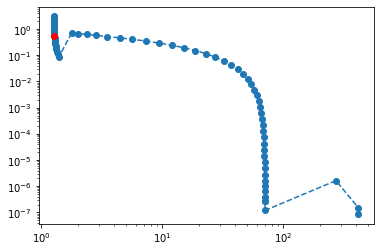

In [29]:
idx = 45
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

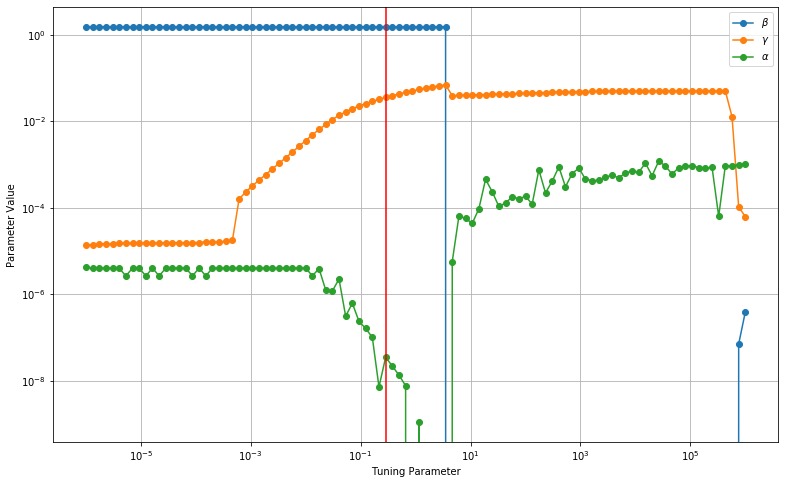

In [30]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\alpha$')
plt.xscale('log')
plt.xlabel('Tuning Parameter')
plt.ylabel('Parameter Value')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()
plt.grid(True)

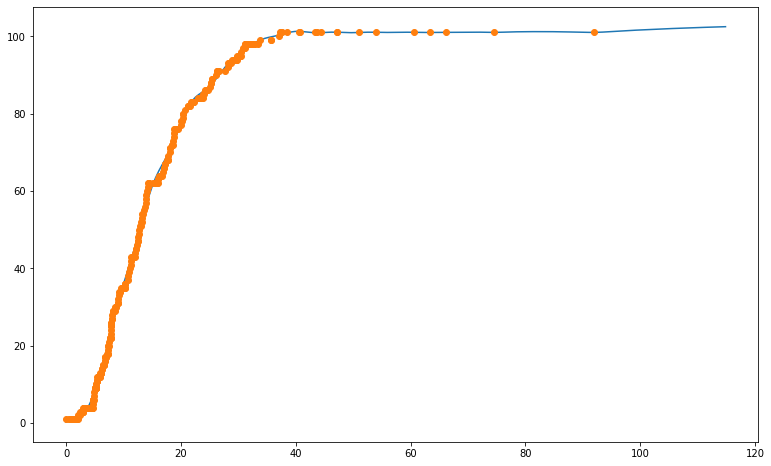

In [31]:
plt.figure(figsize=[13,8])
plt.plot(model.observation_times, getx(sols[idx]['x'])[-1])
plt.plot(data_time, cI, 'o')


In [32]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors


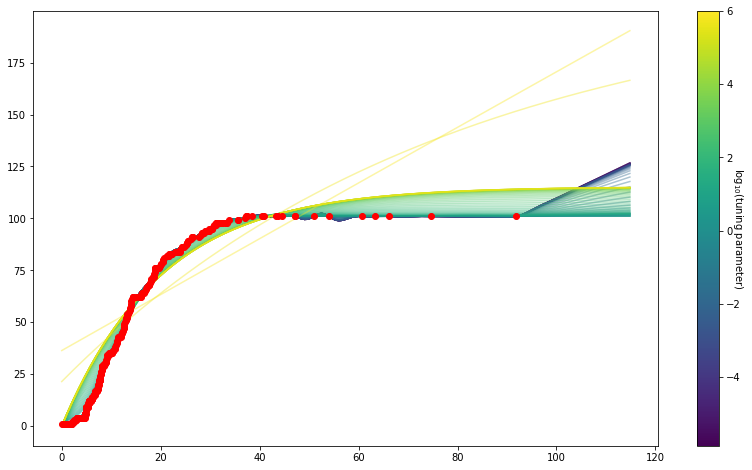

In [33]:

plt.figure(figsize=[14,8])

i0, i1 = (1, -1)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[-1], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(data_time, cI, 'ro', label='Data')
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)